<a href="https://colab.research.google.com/github/PraveenKumarGarlapati/AV_LoanDelinquencyAug15th/blob/master/topic_modelling_lda_on_elon_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.7MB/s 
     |████████████████████████████████| 552kB 38.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=297ef718507eea5dd5c3defd70b05f3d6eaf272aa0e4c65f47b03b7e0c62293d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3557966e3dc3223e0660b31a4a5f60e4ec728d4b74ba43e27e5ea6092788c5b6
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore")

In [0]:
datafile = '/content/US_16k sample.xlsx'

In [0]:
import pandas as pd
tweets1 = pd.read_excel(datafile, encoding='latin1')
tweets = tweets1[['TWEET_BODY','POSTED_TIME','HANDLE','_id']]
tweets.columns = ['Tweet','Time','Retweet from','User']
# tweets = tweets.assign(Time=pd.to_datetime(tweets.Time)).drop('row ID', axis='columns')
# print("Number of tweets: ",len(tweets['Tweet']))
# tweets.head(5)

***Tweet Activity Over Years***

In [10]:
'''import plotly.plotly as py
import plotly.graph_objs as go
'''
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Years',
    height=450,
    width=1200,
    xaxis=dict(
        title='Month and year'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [11]:
# Preparing a corpus for analysis and checking first 10 entries

corpus=[]
a=[]
for i in range(len(tweets['Tweet'])):
        a=tweets['Tweet'][i]
        corpus.append(a)
        
corpus[0:10]

['so much for turning up. instead im in bed eating a pop tart and drinking milk',
 'rt mctherrera pag binaligtad mo ice cream, dairy queen yon',
 'rt thedadvocate01 me new year new menndog new year new fleannbeverage importer new year new teannbank new year new feennaborist new',
 'challenging myself no soda all month only water and treat myself to a lil juice every now and then',
 'rt gonzovice let us toast to animal pleasures, to escapism, to rain on the roof and instant coffee, to unemployment insurance and library',
 'staying away from dark soda and mcdonalds all this year',
 'today is my last day to drink sodaenergy drinks tt tomorrow i go back on my diet. no sugar, minimize all carbs. httpst.col7gk62l7lk',
 'rt bvorwerk men  n  n                 n                                           na healthy, well           ',
 'dairy queen blizzard callin my name ',
 'rt gasbuddyguy the cheapest gasprice in the usn1.48gal at united dairy farmers in columbus, ohio.']

In [12]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [14]:
import nltk
nltk.download('stopwords')

# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2020-03-24 20:33:28,163 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-03-24 20:33:28,343 : INFO : adding document #10000 to Dictionary(21905 unique tokens: ['bed', 'drinking', 'eating', 'im', 'instead']...)
2020-03-24 20:33:28,478 : INFO : built Dictionary(34446 unique tokens: ['bed', 'drinking', 'eating', 'im', 'instead']...) from 16889 documents (total 184385 corpus positions)
2020-03-24 20:33:28,479 : INFO : saving Dictionary object under /tmp/elon.dict, separately None
2020-03-24 20:33:28,495 : INFO : saved /tmp/elon.dict


In [15]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later use

2020-03-24 20:33:37,538 : INFO : storing corpus in Matrix Market format to /tmp/elon.mm
2020-03-24 20:33:37,540 : INFO : saving sparse matrix to /tmp/elon.mm
2020-03-24 20:33:37,541 : INFO : PROGRESS: saving document #0
2020-03-24 20:33:37,564 : INFO : PROGRESS: saving document #1000
2020-03-24 20:33:37,583 : INFO : PROGRESS: saving document #2000
2020-03-24 20:33:37,602 : INFO : PROGRESS: saving document #3000
2020-03-24 20:33:37,622 : INFO : PROGRESS: saving document #4000
2020-03-24 20:33:37,641 : INFO : PROGRESS: saving document #5000
2020-03-24 20:33:37,661 : INFO : PROGRESS: saving document #6000
2020-03-24 20:33:37,681 : INFO : PROGRESS: saving document #7000
2020-03-24 20:33:37,701 : INFO : PROGRESS: saving document #8000
2020-03-24 20:33:37,720 : INFO : PROGRESS: saving document #9000
2020-03-24 20:33:37,741 : INFO : PROGRESS: saving document #10000
2020-03-24 20:33:37,764 : INFO : PROGRESS: saving document #11000
2020-03-24 20:33:37,783 : INFO : PROGRESS: saving document #120

In the previous cells, I created a corpus of documents represented as a stream of vectors. To continue, lets use that corpus, with the help of Gensim.

### Creating a transformation


The transformations are standard Python objects, typically initialized by means of a training corpus:

Different transformations may require different initialization parameters; in case of TfIdf, the “training” consists simply of
going through the supplied corpus once and computing document frequencies of all its features.
Training other models, such as Latent Semantic Analysis or Latent Dirichlet Allocation, is much more involved and,
consequently, takes much more time.

In [16]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2020-03-24 20:33:50,808 : INFO : collecting document frequencies
2020-03-24 20:33:50,810 : INFO : PROGRESS: processing document #0
2020-03-24 20:33:50,853 : INFO : PROGRESS: processing document #10000
2020-03-24 20:33:50,876 : INFO : calculating IDF weights for 16889 documents and 34445 features (176546 matrix non-zeros)


### Note
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where TfIdf vectors are expected, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

From now on, tfidf is treated as a read-only object that can be used to apply a transformation to a whole corpus:

In [0]:
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors

### LDA:
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

Latent Dirichlet Allocation, LDA is yet another transformation from bag-of-words counts into a topic space of lower dimensionality. LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. These distributions are, just like with LSA, inferred automatically from a training corpus. Documents are in turn interpreted as a (soft) mixture of these topics (again, just like with LSA).

In [0]:
total_topics = 5

In [19]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2020-03-24 20:34:00,453 : INFO : using symmetric alpha at 0.2
2020-03-24 20:34:00,455 : INFO : using symmetric eta at 0.2
2020-03-24 20:34:00,470 : INFO : using serial LDA version on this node
2020-03-24 20:34:00,496 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 16889 documents, updating model once every 2000 documents, evaluating perplexity every 16889 documents, iterating 50x with a convergence threshold of 0.001000
2020-03-24 20:34:00,497 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-03-24 20:34:00,498 : INFO : PROGRESS: pass 0, at document #2000/16889
2020-03-24 20:34:01,724 : INFO : merging changes from 2000 documents into a model of 16889 documents
2020-03-24 20:34:01,762 : INFO : topic #0 (0.200): 0.026*"new" + 0.023*"n" + 0.012*"year" + 0.012*"2019" + 0.011*"drink" + 0.010*"day" + 0.009*"one" + 0.009*"energy" + 0.009*"ive" + 0.008*"dri

In [20]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.011*"energy" + 0.011*"day" + 0.010*"2019" + 0.009*"drink" + 0.009*"n"'),
 (1,
  '0.015*"dairy" + 0.014*"brew" + 0.013*"cold" + 0.013*"soda" + 0.013*"hot"'),
 (2,
  '0.012*"tea" + 0.011*"hot" + 0.011*"drinking" + 0.009*"dairy" + 0.009*"soda"'),
 (3,
  '0.068*"new" + 0.034*"year" + 0.010*"coffee" + 0.010*"soda" + 0.009*"happy"'),
 (4,
  '0.017*"drinking" + 0.015*"im" + 0.013*"coffee" + 0.012*"dairy" + 0.011*"soda"')]

In [0]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda

In [22]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 97)


In [23]:
df_lda

,energy,day,2019,drink,n,one,would,days,always,take,tea,dairy,drinking,well,ive,coffee,tv,everybody,gene,studio,rolling,value,laughter.,"nntonight,",indulge,brew,cold,soda,hot,"ever,",chocolate,amp,years,little,cup,house,delicious,resolution,farmers,java,...,im,instant,toast,support,make,new,year,happy,etsy,hollysimental,free,diet,dairy.,shop,farms,ditch,longer,cows,keep,importer,fleannbeverage,menndog,feennaborist,teannbank,food,eat,stop,dont,water,vegan,smoothie,use,protein,people,coffee.,cannot,good,usmcliberal,kcup.nntheyre,mynewyearsresolution
0,0.01085,0.010537,0.010344,0.009069,0.008843,0.008327,0.008212,0.006168,0.006135,0.005855,0.005828,0.005814,0.005494,0.005022,0.004863,0.004684,0.004532,0.004198,0.004132,0.004078,0.004074,0.004027,0.00401,0.00401,0.003963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.004046,0.005108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015168,0.004042,0.000000,0.000000,0.006849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.013812,0.013151,0.013029,0.012735,0.010901,0.008262,0.006345,0.006066,0.005267,0.005143,0.005003,0.004732,0.004727,0.00433,0.004259,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012122,0.009412,0.010810,0.000000,0.000000,0.008247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.009160,0.011249,0.000000,0.008808,0.005860,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.003336,0.003178,0.003142,0.00305,0.003028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009037,0.008494,0.000000,0.000000,0.010394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.010268,0.000000,0.000000,0.000000,0.000000,0.008651,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.068166,0.033784,0.009152,0.006072,0.005391,0.004129,0.004118,0.003931,0.003918,0.003487,0.003467,0.003373,0.003287,0.003151,0.003109,0.003105,0.003105,0.003103,0.003101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.004145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011819,0.017150,0.000000,0.000000,0.013012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.010583,0.003978,0.000000,0.004263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.014550,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

2020-03-24 20:34:20,272 : INFO : NumExpr defaulting to 2 threads.


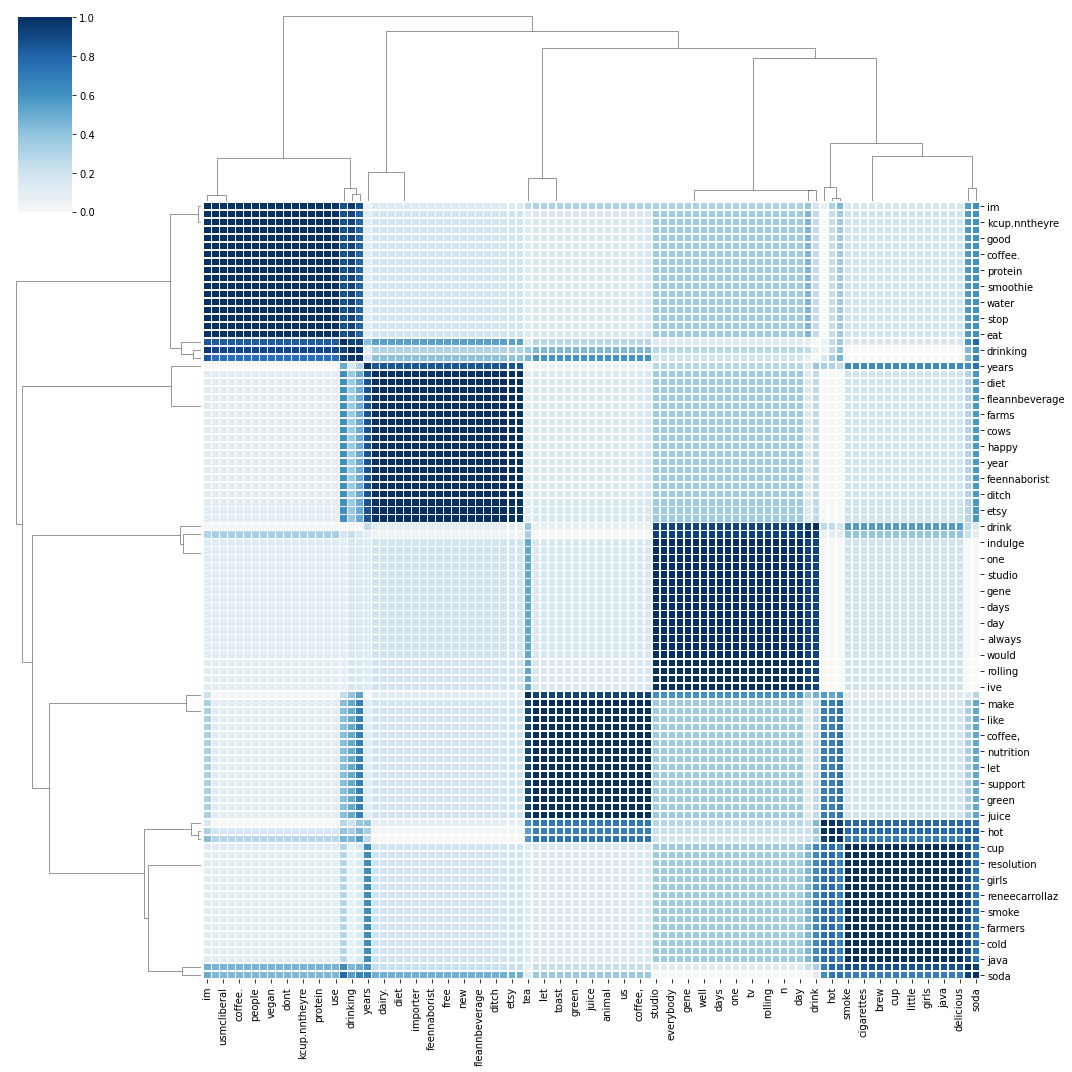

In [24]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

In [25]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

KeyboardInterrupt: ignored